# Jonathan Halverson
# Monday, April 17, 2017
# Part 16: More on win ratios

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

In [2]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [3]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
cols = ['Name', 'Dob', 'Stance', 'Reach']
fights = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
fights = fights.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
fights = fights.drop(['Name', 'Name_L'], axis=1)
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Dob,Stance,Reach,Dob_L,Stance_L,Reach_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1984-04-24,Orthodox,71.0,1981-10-17,Southpaw,69.0
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1975-04-14,Southpaw,77.0,1984-01-04,Southpaw,77.0
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1979-12-07,Orthodox,72.0,1981-01-28,Orthodox,74.0


### Remove no contests but leave in draws

In [4]:
f = fights[fights.Outcome != 'no contest'].copy()

In [5]:
# below we use the index to find previous fights since in early days they fought
# multiple times per day so date cannot be used

NumPreviousFights = []
NumPreviousFights_L = []
NumPreviousWins = []
NumPreviousWins_L = []
for index, row in f.iterrows():
     winner = row['Winner']
     a = f[((f.Winner == winner) | (f.Loser == winner)) & (f.index > index)]
     NumPreviousFights.append(a.shape[0])
     NumPreviousWins.append(a[a.Winner == winner].shape[0])
     
     loser = row['Loser']
     b = f[((f.Winner == loser) | (f.Loser == loser)) & (f.index > index)]
     NumPreviousFights_L.append(b.shape[0])
     NumPreviousWins_L.append(b[b.Winner == loser].shape[0])

f['NumPreviousFights'] = NumPreviousFights
f['NumPreviousFights_L'] = NumPreviousFights_L
f['NumPreviousWins'] = NumPreviousWins
f['NumPreviousWins_L'] = NumPreviousWins_L

### Now remove draws and older fights

In [6]:
f = f[(f.Date > pd.to_datetime('2005-01-01')) & (f.Outcome == 'def.')]

In [7]:
f['WinRatio'] = f.NumPreviousWins / f.NumPreviousFights
f['WinRatio_L'] = f.NumPreviousWins_L / f.NumPreviousFights_L

In [8]:
def WinRatio_Age_Reach(x):
     from random import random as rng
     
     if x.WinRatio > x.WinRatio_L: return True
     if (x.WinRatio == x.WinRatio_L) and (x.Dob > x.Dob_L):
          return True
     else:
          return False
     if (x.WinRatio == x.WinRatio_L) and (x.Dob == x.Dob_L) and (x.Reach > x.Reach_L):
          return True
     else:
          return False
     # if total equality then return guess of True
     if (x.WinRatio == x.WinRatio_L) and (x.Dob == x.Dob_L) and (x.Reach == x.Reach_L):
          return True if rng() >= 0.5 else False

In [9]:
f.head()

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Dob,Stance,Reach,Dob_L,Stance_L,Reach_L,NumPreviousFights,NumPreviousFights_L,NumPreviousWins,NumPreviousWins_L,WinRatio,WinRatio_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1984-04-24,Orthodox,71.0,1981-10-17,Southpaw,69.0,4,5,3,3,0.750000,0.600000
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1975-04-14,Southpaw,77.0,1984-01-04,Southpaw,77.0,20,9,16,7,0.800000,0.777778
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1979-12-07,Orthodox,72.0,1981-01-28,Orthodox,74.0,7,20,6,11,0.857143,0.550000
3,Glover Teixeira,def.,Jared Cannonier,Light Heavyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1979-10-28,Orthodox,76.0,1984-03-16,Switch,77.0,11,3,8,2,0.727273,0.666667
4,Dustin Poirier,def.,Jim Miller,Lightweight,M-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",1989-01-19,Southpaw,72.0,1983-08-30,Southpaw,71.0,16,24,12,17,0.750000,0.708333


In [10]:
f.shape

(3561, 23)

### How many NaN are there?

In [11]:
all_nans = pd.isnull(f.WinRatio).sum() + pd.isnull(f.WinRatio_L).sum()
all_nans

1301

In [12]:
all_nans / (2.0 * f.shape[0])

0.18267340634653187

So 18.3% of all the win ratios (of winner and loser) need to be replaced.

### Greater number of UFC fights wins

In [13]:
wins = f[f.NumPreviousFights > f.NumPreviousFights_L].shape[0]
total = f[f.NumPreviousFights != f.NumPreviousFights_L].shape[0]
wins / float(total), total

(0.5564795564795565, 2886)

### How many fights where both fighters are debutting?

In [14]:
cond = f[(f.NumPreviousFights == 0) & (f.NumPreviousFights_L == 0)].shape[0]
cond, 100 * cond / float(f.shape[0])

(299, 8.396517832069643)

### How many fights where at least one fighter is debutting?

In [15]:
cond = f[(f.NumPreviousFights == 0) | (f.NumPreviousFights_L == 0)].shape[0]
cond, 100 * cond / float(f.shape[0])

(1002, 28.13816343723673)

### How many fights where only one fighter is debutting?

In [16]:
msk1 = ((f.NumPreviousFights == 0) & (f.NumPreviousFights_L != 0))
msk2 = ((f.NumPreviousFights != 0) & (f.NumPreviousFights_L == 0))
cond = f[msk1 | msk2].shape[0]
cond, 100 * cond / float(f.shape[0])

(703, 19.741645605167086)

### Greater win ratio wins

In [17]:
tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L) & (f.WinRatio != f.WinRatio_L)]
wins = tmp[tmp.WinRatio > tmp.WinRatio_L].shape[0]
total = tmp.shape[0]
wins / float(total), wins, total

(0.57182966775854, 1222, 2137)

In [18]:
tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L) & (f.WinRatio != f.WinRatio_L) & (f.NumPreviousFights >= 5) & (f.NumPreviousFights_L >= 5)]
wins = tmp[tmp.WinRatio > tmp.WinRatio_L].shape[0]
total = tmp.shape[0]
wins / float(total), wins, total

(0.5956580732700135, 439, 737)

### Apply boolean model defined above

In [19]:
tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L)].apply(WinRatio_Age_Reach, axis=1)
wins = tmp.sum()
total = tmp.shape[0]
wins / float(total), wins, total

(0.56897225478702618, 1456, 2559)

In [20]:
f['WinRatio'] = f.NumPreviousWins / f.NumPreviousFights
f['WinRatio_L'] = f.NumPreviousWins_L / f.NumPreviousFights_L
f.WinRatio = f.WinRatio.fillna(0.0)
f.WinRatio_L = f.WinRatio_L.fillna(0.0)

results0 = []
for m in range(0, 23):
     tmp = f[(f.NumPreviousFights >= m) & (f.NumPreviousFights_L >= m)]
     bools = tmp.apply(WinRatio_Age_Reach, axis=1)
     wins = bools.sum()
     total = bools.shape[0]
     results0.append((m, wins / float(total), total))

(0, 1500)

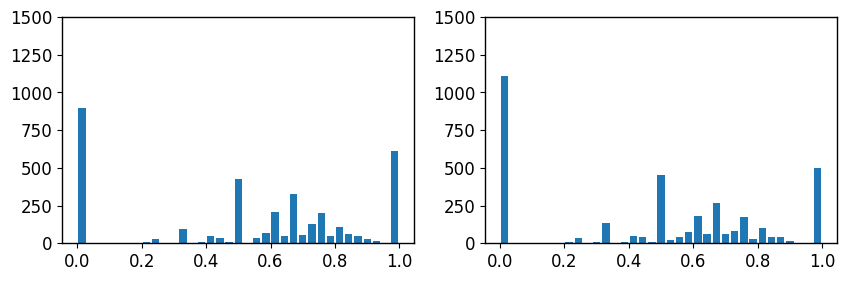

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax1.hist(f[pd.notnull(f.WinRatio)].WinRatio, bins=35, rwidth=0.8)
ax1.set_ylim(0, 1500)
ax2.hist(f[pd.notnull(f.WinRatio_L)].WinRatio_L, bins=35, rwidth=0.8)
ax2.set_ylim(0, 1500)

In [22]:
f['WinRatio'] = f.NumPreviousWins / f.NumPreviousFights
f['WinRatio_L'] = f.NumPreviousWins_L / f.NumPreviousFights_L
# leave in the NaNs
results1 = []
for m in range(0, 23):
     tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L) & (f.WinRatio != f.WinRatio_L) & (f.NumPreviousFights >= m) & (f.NumPreviousFights_L >= m)]
     wins = tmp[tmp.WinRatio > tmp.WinRatio_L].shape[0]
     total = tmp.shape[0]
     results1.append((m, wins / float(total), total))

In [23]:
f.WinRatio = f.WinRatio.fillna(0.0)
f.WinRatio_L = f.WinRatio_L.fillna(0.0)
results2 = []
for m in range(0, 23):
     tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L) & (f.WinRatio != f.WinRatio_L) & (f.NumPreviousFights >= m) & (f.NumPreviousFights_L >= m)]
     wins = tmp[tmp.WinRatio > tmp.WinRatio_L].shape[0]
     total = tmp.shape[0]
     results2.append((m, wins / float(total), total))

(0, 1500)

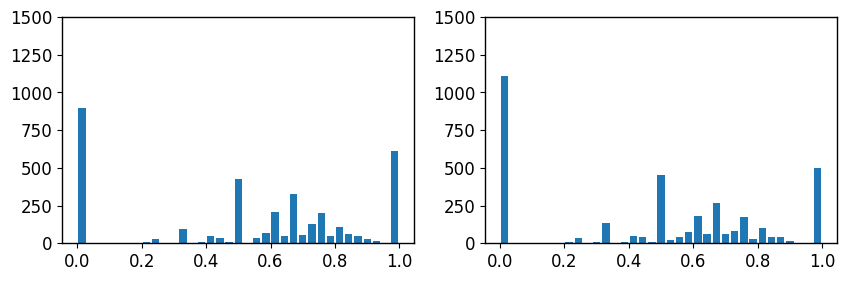

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax1.hist(f[pd.notnull(f.WinRatio)].WinRatio, bins=35, rwidth=0.8)
ax1.set_ylim(0, 1500)
ax2.hist(f[pd.notnull(f.WinRatio_L)].WinRatio_L, bins=35, rwidth=0.8)
ax2.set_ylim(0, 1500)

In [25]:
f['WinRatio'] = f.NumPreviousWins / f.NumPreviousFights
f['WinRatio_L'] = f.NumPreviousWins_L / f.NumPreviousFights_L
f.WinRatio = f.WinRatio.fillna(0.5)
f.WinRatio_L = f.WinRatio_L.fillna(0.5)
results3 = []
for m in range(0, 23):
     tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L) & (f.WinRatio != f.WinRatio_L) & (f.NumPreviousFights >= m) & (f.NumPreviousFights_L >= m)]
     wins = tmp[tmp.WinRatio > tmp.WinRatio_L].shape[0]
     total = tmp.shape[0]
     results3.append((m, wins / float(total), total))

In [26]:
f['WinRatio'] = f.NumPreviousWins / f.NumPreviousFights
f['WinRatio_L'] = f.NumPreviousWins_L / f.NumPreviousFights_L
f.WinRatio = f.WinRatio.fillna(1.0)
f.WinRatio_L = f.WinRatio_L.fillna(1.0)
results4 = []
for m in range(0, 23):
     tmp = f[pd.notnull(f.WinRatio) & pd.notnull(f.WinRatio_L) & (f.WinRatio != f.WinRatio_L) & (f.NumPreviousFights >= m) & (f.NumPreviousFights_L >= m)]
     wins = tmp[tmp.WinRatio > tmp.WinRatio_L].shape[0]
     total = tmp.shape[0]
     results4.append((m, wins / float(total), total))

In [27]:
f[(f.NumPreviousFights >= 0) & (f.NumPreviousFights_L >= 0)].shape[0]

3561

(0, 1750)

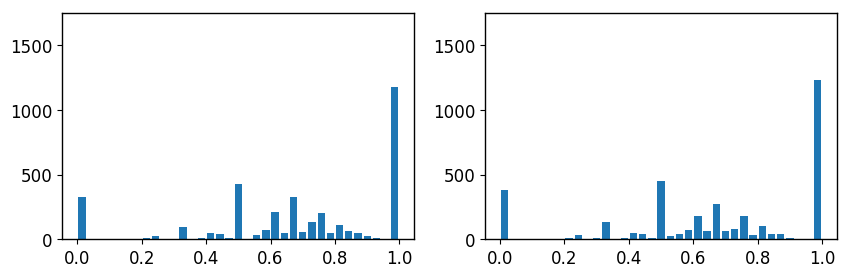

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
ax1.hist(f[pd.notnull(f.WinRatio)].WinRatio, bins=35, rwidth=0.8)
ax1.set_ylim(0, 1750)
ax2.hist(f[pd.notnull(f.WinRatio_L)].WinRatio_L, bins=35, rwidth=0.8)
ax2.set_ylim(0, 1750)

In [29]:
df0 = pd.DataFrame(results0)
df0.columns = ['m', 'Accuracy', 'Total']
df1 = pd.DataFrame(results1)
df1.columns = ['m', 'Accuracy', 'Total']
df2 = pd.DataFrame(results2)
df2.columns = ['m', 'Accuracy', 'Total']
df3 = pd.DataFrame(results3)
df3.columns = ['m', 'Accuracy', 'Total']
df4 = pd.DataFrame(results4)
df4.columns = ['m', 'Accuracy', 'Total']

### Let's vary minimum number of fights and see how the "greater win ratio wins" model does

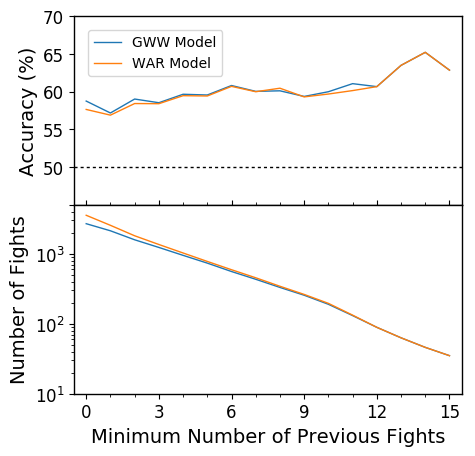

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 5), sharex='all')
#plt.scatter(df1.m, 100*df1.Accuracy, label='Drop')
ax1.plot(df2.m[0:16], 100*df2.Accuracy[0:16], label='GWW Model')
ax1.plot(df0.m[0:16], 100*df0.Accuracy[0:16], label='WAR Model')
#plt.plot(df3.m, 100*df3.Accuracy, label='NaN=1/2')
#plt.scatter(df4.m, 100*df4.Accuracy, label='NaN=1')
ax1.plot([-0.5, 20], [50, 50], 'k:')
ax1.set_xlim(-0.5, 15.5)
ax1.set_ylim(45, 70)
ax1.set_ylabel('Accuracy (%)')
ax1.legend()

ax1.set_xticklabels([])
major_ticks_ = np.arange(0, 16, 3)
ax1.set_xticks(major_ticks_)
minor_ticks_ = np.arange(0, 16, 1)
ax1.set_xticks(minor_ticks_, minor=True)
ax1.tick_params(axis='x', direction='in', which='both')
plt.setp(ax1.get_yticklabels()[0], visible=False)

#ax2.semilogy(df2.m[0:16], df2.Total[0:16])
ax2.semilogy(df2.m[0:16], df2.Total[0:16])
ax2.semilogy(df0.m[0:16], df0.Total[0:16], label='WAR Model')
#ax2.plot(df2.m[0:16], df2.Total[0:16]/float(f.shape[0]))

ax2.set_xlabel('Minimum Number of Previous Fights')
ax2.set_ylabel('Number of Fights')
ax2.set_ylim(10, 5000)

ax2.set_xticks(major_ticks_)
ax2.set_xticklabels(major_ticks_)
ax2.set_xticks(minor_ticks_, minor=True)

fig.subplots_adjust(hspace=0)
plt.savefig('report/prediction/win_ratio_model.pdf', bbox_inches='tight')

This figure is telling us that when both fighters have m fights or more, we can use this simple model of greater win ratio wins and get an accuracy of about 59% which is almost as good as our ML classifiers.

All values are the same after m=0 since nothing is imputed for those cases.

In [31]:
pd.concat([df0, df1, df2, df3, df4], axis=1)

,m,Accuracy,Total,m,Accuracy,Total,m,Accuracy,Total,m,Accuracy,Total,m,Accuracy,Total
0,0,0.576523,3561,0,0.571830,2137,0,0.587625,2699,0,0.577901,2715,0,0.539092,2686
1,1,0.568972,2559,1,0.571830,2137,1,0.571830,2137,1,0.571830,2137,1,0.571830,2137
2,2,0.584344,1814,2,0.590308,1589,2,0.590308,1589,2,0.590308,1589,2,0.590308,1589
3,3,0.584129,1361,3,0.585425,1235,3,0.585425,1235,3,0.585425,1235,3,0.585425,1235
4,4,0.594752,1029,4,0.596639,952,4,0.596639,952,4,0.596639,952,4,0.596639,952
5,5,0.594352,779,5,0.595658,737,5,0.595658,737,5,0.595658,737,5,0.595658,737
6,6,0.607083,593,6,0.608229,559,6,0.608229,559,6,0.608229,559,6,0.608229,559
7,7,0.600000,455,7,0.600462,433,7,0.600462,433,7,0.600462,433,7,0.600462,433
8,8,0.604651,344,8,0.601208,331,8,0.601208,331,8,0.601208,331,8,0.601208,331
9,9,0.593156,263,9,0.593750,256,9,0.593750,256,9,0.593750,256,9,0.593750,256


In [32]:
df2[3:11]

,m,Accuracy,Total
3,3,0.585425,1235
4,4,0.596639,952
5,5,0.595658,737
6,6,0.608229,559
7,7,0.600462,433
8,8,0.601208,331
9,9,0.593750,256
10,10,0.600000,190


In [33]:
df2[3:11].mean()

m             6.500000
Accuracy      0.597671
Total       586.625000
dtype: float64

In [34]:
df0[3:11].mean()

m             6.500000
Accuracy      0.596883
Total       627.500000
dtype: float64

# Fit a logistic regression model using only the difference in win ratio

In [35]:
f['WinRatio'] = f.NumPreviousWins / f.NumPreviousFights
f['WinRatio_L'] = f.NumPreviousWins_L / f.NumPreviousFights_L
f.WinRatio = f.WinRatio.fillna(0.0)
f.WinRatio_L = f.WinRatio_L.fillna(0.0)
f['WinRatioDiff'] = f.WinRatio - f.WinRatio_L

In [36]:
f[['Winner', 'Loser', 'WinRatio', 'WinRatio_L', 'WinRatioDiff']].head(10)

,Winner,Loser,WinRatio,WinRatio_L,WinRatioDiff
0,Germaine de Randamie,Holly Holm,0.750000,0.600000,0.150000
1,Anderson Silva,Derek Brunson,0.800000,0.777778,0.022222
2,Jacare Souza,Tim Boetsch,0.857143,0.550000,0.307143
3,Glover Teixeira,Jared Cannonier,0.727273,0.666667,0.060606
4,Dustin Poirier,Jim Miller,0.750000,0.708333,0.041667
5,Belal Muhammad,Randy Brown,0.333333,0.750000,-0.416667
6,Wilson Reis,Ulka Sasaki,0.714286,0.500000,0.214286
7,Islam Makhachev,Nik Lentz,0.666667,0.687500,-0.020833
8,Rick Glenn,Phillipe Nover,0.000000,0.166667,-0.166667
9,Ryan LaFlare,Roan Carneiro,0.833333,0.500000,0.333333


### Need to flip around fighters

In [37]:
from random import random
shuffled = []
for index, row in f.iterrows():
     if random() > 0.5:
          shuffled.append((1, row['WinRatioDiff'], row['NumPreviousFights'], row['NumPreviousFights_L']))
     else:
          shuffled.append((0, -row['WinRatioDiff'], row['NumPreviousFights_L'], row['NumPreviousFights']))

In [38]:
data = pd.DataFrame(shuffled)
data.columns = ['Classes', 'WinRatioDiff', 'NumPreviousFights_1', 'NumPreviousFights_2']
data.head()

,Classes,WinRatioDiff,NumPreviousFights_1,NumPreviousFights_2
0,1,0.150000,4,5
1,1,0.022222,20,9
2,0,-0.307143,20,7
3,1,0.060606,11,3
4,0,-0.041667,24,16


In [39]:
data.shape

(3561, 4)

### Check for outliers

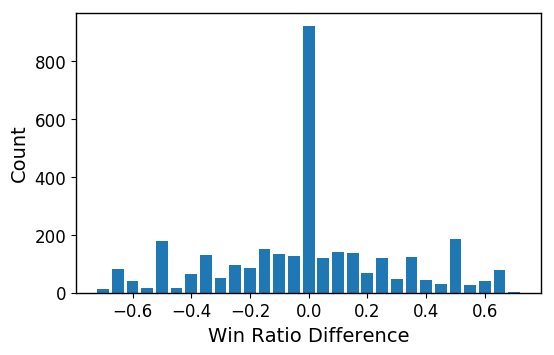

In [40]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.hist(data.WinRatioDiff, bins=np.arange(-0.725, 0.725+0.05, step=0.05), rwidth=0.8)
ax1.set_xlabel('Win Ratio Difference')
ax1.set_ylabel('Count')

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [64]:
from sklearn.linear_model import LogisticRegression

m_accuracy = []
for m in range(0, 16):
     g = data[(data.NumPreviousFights_1 >= m) & (data.NumPreviousFights_2 >= m)]

     X = g.WinRatioDiff.values.reshape(-1, 1)
     y = g.Classes.values
     stdsc = StandardScaler()
     StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
     param_grid = dict(C=np.logspace(-4, 1, base=10, num=25), penalty=['l1', 'l2'])
     test_accuracies = []
     brier_accuracies = []
     for i in range(10):
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
          clf = LogisticRegression()
          grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
          X_std = stdsc.fit_transform(X_train)
          grid.fit(X_std, y_train)
          # predict test labels
          y_test_pred = grid.predict(stdsc.transform(X_test))
          test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
          test_accuracies.append(test_accuracy)
          y_test_proba = grid.predict_proba(stdsc.transform(X_test))[:,1]
          brier_score = metrics.brier_score_loss(y_true=y_test, y_prob=y_test_proba)
          brier_accuracies.append(brier_score)
     print m, g.shape[0], np.array(test_accuracies).mean(), np.array(brier_accuracies).mean()
     m_accuracy.append((m, g.shape[0], np.array(test_accuracies).mean(), np.array(brier_accuracies).mean()))

0 0.566323666978 0.24577328172
1 0.555338541667 0.247616697428
2 0.583486238532 0.245123728697
3 0.576039119804 0.247049505045
4 0.607766990291 0.244977600068
5 0.602991452991 0.242964674128
6 0.591011235955 0.243354428581
7 0.59197080292 0.242362742609
8 0.555769230769 0.245251096451
9 0.594936708861 0.241560101093
10 0.650847457627 0.239412806878


In [44]:
w0 = grid.best_estimator_.intercept_[0]
w1 = grid.best_estimator_.coef_[0][0]
w0, w1

(9.4135366657251374e-05, 0.017760152489205882)

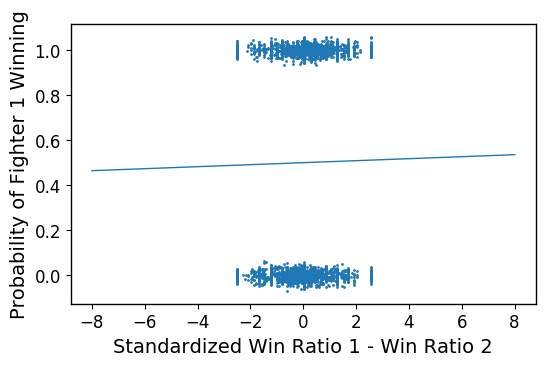

In [45]:
from scipy.stats import norm
dw = np.linspace(-8, 8)
plt.scatter(stdsc.transform(data.WinRatioDiff.values.reshape(-1, 1)), data.Classes.values+norm.rvs(scale=0.02, size=y.size), s=1)
plt.plot(dw, 1.0 / (1.0 + np.exp(-w0 - w1 * dw)))
plt.xlabel('Standardized Win Ratio 1 - Win Ratio 2')
plt.ylabel('Probability of Fighter 1 Winning')

The transition from 0 to 1 is:

In [46]:
-w0/w1

-0.0053003692797381208

# Statsmodels

Below we use Statsmodels to perform the fit so that we can see the p-values:

In [47]:
import statsmodels.api as sm
from statsmodels import discrete

#X = data[['WinRatioDiff', 'NumPreviousFights_1', 'NumPreviousFights_2']].values
X = data.WinRatioDiff.values.reshape(-1, 1)
y = data.Classes.values
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

X = sm.add_constant(X)
logit_model = discrete.discrete_model.Logit(y, X, missing='none')
result = logit_model.fit_regularized(method='l1', alpha=10.0)
print result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.682831809366
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3561
Model:                          Logit   Df Residuals:                     3559
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Apr 2017   Pseudo R-squ.:                 0.01779
Time:                        19:24:09   Log-Likelihood:                -2424.1
converged:                       True   LL-Null:                       -2468.1
                                        LLR p-value:                 7.130e-21
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
con

In [48]:
v = np.vectorize(round)
y_pred = v(1.0 / (1.0 + np.exp(-X_std*0.2853))).flatten()

In [49]:
metrics.accuracy_score(y, y_pred)

0.56809884863802307

### Try fitting idealized data

In [50]:
x = np.linspace(0, 1)
y = v(x)

In [51]:
x = x + norm.rvs(loc=0, scale=0.1, size=x.size)

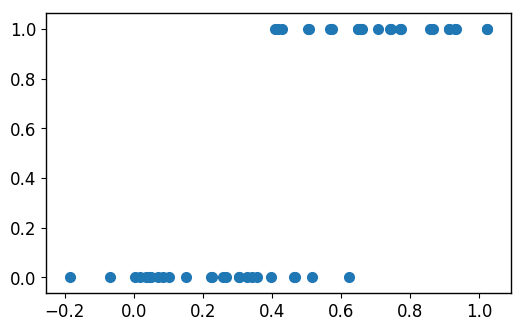

In [52]:
plt.scatter(x, y)

In [53]:
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', refit=True)
grid.fit(x.reshape(-1, 1), y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.61560e-04,   2.61016e-04,   4.21697e-04,
         6.81292e-04,   1.10069e-03,   1.77828e-03,   2.87298e-03,
         4.64159e-03,   7.49894e-03,   1.21153e-02,   1.95734e-02,
         3.16228e-02,   5.10897e-02,   8.25404e-02,   1.33352e-01,
         2.15443e-01,   3.48070e-01,   5.62341e-01,   9.08518e-01,
         1.46780e+00,   2.37137e+00,   3.83119e+00,   6.18966e+00,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [54]:
w1 = grid.best_estimator_.coef_[0][0]
w1

1.3703281400925573

In [55]:
w0 = grid.best_estimator_.intercept_[0]
w0

-0.51425580470306198

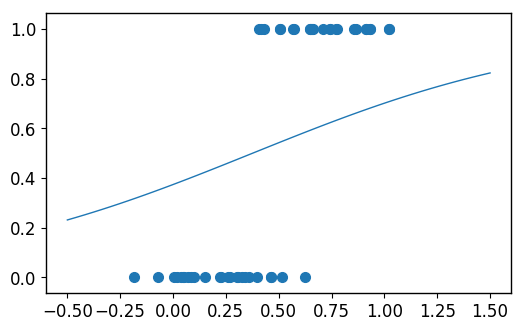

In [56]:
z = np.linspace(-0.5, 1.5)
plt.scatter(x, y)
plt.plot(z, 1.0 / (1 + np.exp(-w0 -w1*z)))

In [57]:
-w0/w1

0.37527931424390593

### Another example

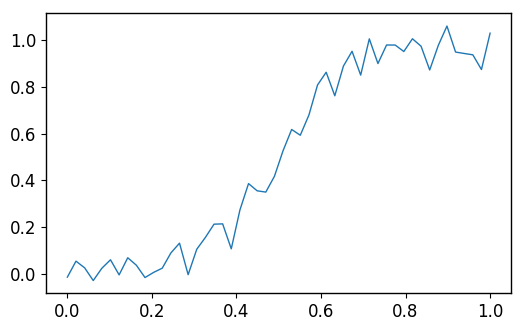

In [58]:
x = np.linspace(0, 1, num=50)
y = 0.5 * (np.tanh(6*x - 3) + 1) + norm.rvs(scale=0.05, size=x.size)
plt.plot(x, y)

In [59]:
y = v(y)

In [60]:
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', refit=True)
grid.fit(x.reshape(-1, 1), y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-04,   1.61560e-04,   2.61016e-04,   4.21697e-04,
         6.81292e-04,   1.10069e-03,   1.77828e-03,   2.87298e-03,
         4.64159e-03,   7.49894e-03,   1.21153e-02,   1.95734e-02,
         3.16228e-02,   5.10897e-02,   8.25404e-02,   1.33352e-01,
         2.15443e-01,   3.48070e-01,   5.62341e-01,   9.08518e-01,
         1.46780e+00,   2.37137e+00,   3.83119e+00,   6.18966e+00,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [61]:
w0 = grid.best_estimator_.intercept_[0]
w1 = grid.best_estimator_.coef_[0][0]
w0, w1

(-2.9693025073184316, 6.2434273801515392)

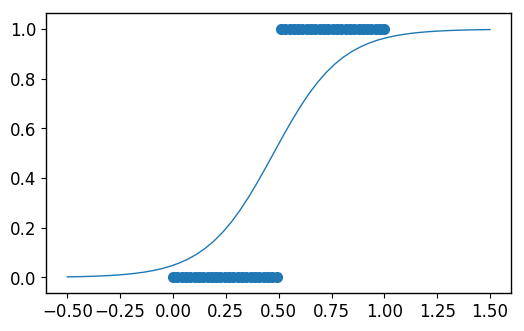

In [62]:
z = np.linspace(-0.5, 1.5)
plt.scatter(x, y)
plt.plot(z, 1.0 / (1 + np.exp(-w0 -w1*z)))

The transition from predicting 0 to 1 occurs at:

In [63]:
-w0/w1

0.47558853919853894